In [126]:
import lightgbm

# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data            # 569개의 데이터에 대해 30개의 feature가 담겨 있음
target = dataset.target   # 569개에 대한 정답 set (1d nparray)
pd.DataFrame(ftr).head()          

X_train, X_val, y_train, y_val=train_test_split(ftr, target, test_size=0.2, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정. 
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(X_val, y_val)]                 # val dataset을 (data, target) 형식의 tuple in list로 만들어 넣어준다
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",  eval_set=evals)
print (X_train.dtype, X_val.dtype, y_train.dtype, y_val.dtype)

# preds = lgbm_wrapper.predict(X_val)
# pred_proba = lgbm_wrapper.predict_proba(X_val)[:, 1]

print (pd.DataFrame(y_val).head())

/home/goldpm1/miniconda3/envs/cnvpytor/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

In [180]:
import matplotlib.pyplot as plt
import scipy.stats as stats


def tr (df, mixture, target):
    d = pd.DataFrame(np.array(df).transpose(), columns = [i for i in range (mixture.shape[0])])
    d["target"] = target
    return d


TRAIN_NO = 500

mixture = np.array([[0.42, 0.04, 0.23, 0.31], [0.15, 0.02, 0.6 , 0.23]])
train_df = pd.DataFrame(columns = [i for i in range (mixture.shape[0])] + ["target"])

lgbm_wrapper = LGBMClassifier(n_estimators=400)

for row in range(3):
    Train_inside =  [None] * mixture.shape[0]       # 일단 빈 list를 잡아놓고
    Train_outside =  [None] * mixture.shape[0]       # 일단 빈 list를 잡아놓고

    for col in range(mixture.shape[0]):
        # 1. 정규분포 추출 (truncated ND)      
        lower, upper, mu, sigma = 0, mixture[col, row], 0, (mixture[col, row]  / 4)
        Inside1 = stats.truncnorm( (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        lower, upper, mu, sigma = 0, mixture[col, row], mixture[col, row], (mixture[col, row]  / 4)
        Inside2 = stats.truncnorm( (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        Train_inside[col] = np.array ( Inside1.rvs(TRAIN_NO)+ list(Inside2.rvs(TRAIN_NO)) )

        lower, upper, mu, sigma = mixture[col, row], 1, mixture[col, row], (mixture[col, row]  / 3)
        Outside = stats.truncnorm( (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
        Train_outside[col] = Outside.rvs(TRAIN_NO)

        # 2. 등간격 추출
        # Train_inside[col] = np.random.uniform (0, mixture[col, row], TRAIN_NO)
        # Train_outside[col] = np.random.uniform (mixture[col, row], 1, TRAIN_NO)
        
    d_inside = tr(Train_inside, mixture, 0)   # 0 : inside
    d_outside = tr(Train_outside, mixture, 1)  # 1 : outside

    train_df = pd.concat([train_df, d_inside, d_outside], ignore_index = True)
print (train_df)

# X_train = np.array (train_df.iloc[:,:-1])
# y_train = np.array (train_df.iloc[:,-1]); 


# # train set을 다시 train set과 validation set으로 나눔
# X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.2)
# y_train=y_train.astype('int'); y_val=y_val.astype('int')

# evals = [(X_val, y_val)]                 # val dataset을 (data, target) 형식의 tuple in list로 만들어 넣어준다
# lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",  eval_set=evals)


             0         1 target
0     0.460549  0.136477      0
1     0.255248  0.156651      0
2     0.467153  0.115881      0
3     0.337177  0.126604      0
4     0.408333  0.132554      0
...        ...       ...    ...
2995  0.235045  0.607321      1
2996  0.274181  0.751445      1
2997  0.298301  0.854645      1
2998  0.265549  0.646026      1
2999  0.313702  0.758005      1

[3000 rows x 3 columns]


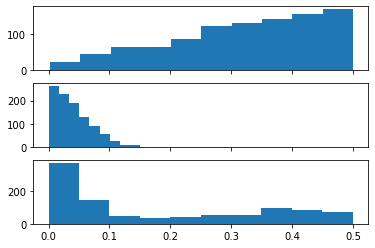

In [184]:
import matplotlib.pyplot as plt
import scipy.stats as stats

lower, upper, mu, sigma = 0, 0.5, 0.5, 0.25
X1 = stats.truncnorm( (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
lower, upper, mu, sigma = 0, 0.5, 0, 0.05
X2 = stats.truncnorm( (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

fig, ax = plt.subplots(3, sharex=True)
ax[0].hist(X1.rvs(1000))
ax[1].hist(X2.rvs(1000))
ax[2].hist(list(X1.rvs(500)) + list(X2.rvs(500)))
plt.show()

In [189]:
for row in range(mixture.shape[1]):
    for col in range(mixture.shape[0]):

0.57